In [1]:
# Installation
!pip install git+https://github.com/openai/CLIP.git
# Download weights
!wget https://github.com/Zasder3/model_soups_colab/releases/download/weights/cifar1098_idxs.npy

  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-yro656di
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-yro656di
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 3.3 MB/s eta 0:00:00
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369489 sha256=1fd234e26f81c4de57b6303b2d0ce6fe5b9aba9a40fc543324a1284db0f74732
  Stored in directory: /tmp/pip-ephem-wheel-cache-uuf1br7e/wheels/da/2b/4c/d6691fa9597aac8bb85d2ac13b112deb897d5b50f5ad9a37e4
Successfully built clip
--2024-12-18 07:41:56--  https://github.com/Zasder3/model_soups_colab/releases/download/weights/cifar1098_idxs.npy
Resolving github.com (github.com)... 20.205.243.166
Connecting to github.com (github.com)|20.205.243.166|:443... connected.
HTTP request sent, awaiting response... 302 Found
Locat

# Model Soups 🍲

By starting with a pretrained model, we can perform supervised finetuning on a new task. Instead of only taking the best performing model of all of our runs, the authors found that we can do some principled averaging to achieve a better set of weights! To learn more read their excellent [paper](https://arxiv.org/abs/2203.05482).

Here we start with CLIP ViT-B/32 and finetune on CIFAR10. The authors of the paper generously provided finetuned weights! I've saved us some time and uploaded the first 5 to GitHub.
All models can be found [here](https://drive.google.com/drive/folders/1KWNs03JRJM7i1CI3Mybpc9TsATY-fXNI).

In [3]:
import torch
import clip
import numpy as np
import matplotlib.pyplot as plt
import os
import math
from torchvision.datasets import CIFAR10
from torchvision.transforms import *
from tqdm.notebook import tqdm

In [4]:
from torch.utils.data.dataset import Subset
from torchvision.transforms import InterpolationMode
BICUBIC = InterpolationMode.BICUBIC

def _convert_image_to_rgb(image):
    return image.convert("RGB")


def _transform(n_px):
    return Compose([
        Resize(n_px, interpolation=BICUBIC),
        CenterCrop(n_px),
        _convert_image_to_rgb,
        ToTensor(),
        Normalize((0.48145466, 0.4578275, 0.40821073), (0.26862954, 0.26130258, 0.27577711)),
    ])

transforms = _transform(224)

idxs = np.load('cifar1098_idxs.npy').astype('int')
indices = []
for i in range(len(idxs)):
  if idxs[i]:
    indices.append(i)

val = CIFAR10(root='./data', train=True, download=True, transform=transforms)
val = Subset(val, indices)
test = CIFAR10(root='./data', train=False, download=True, transform=transforms)

valloader = torch.utils.data.DataLoader(val,
                                        batch_size=128,
                                        shuffle=False,
                                        num_workers=2,
                                        drop_last=False)
testloader = torch.utils.data.DataLoader(test,
                                         batch_size=128,
                                         shuffle=False,
                                         num_workers=2,
                                         drop_last=False)

100%|██████████| 170M/170M [00:13<00:00, 13.0MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [157]:
def validate(model):
  preds = []
  labels = []
  for x, y in tqdm(valloader):
    x = x.to(device)
    y = y.to(device)
    preds.append(model(x).argmax(dim=1))
    labels.append(y)
  return torch.mean((torch.cat(preds) == torch.cat(labels)).float()).item()

def test(model):
  preds = []
  labels = []
  for x, y in tqdm(testloader):
    x = x.to(device)
    y = y.to(device)
    preds.append(model(x).argmax(dim=1))
    labels.append(y)
  return torch.mean((torch.cat(preds) == torch.cat(labels)).float()).item()

In [158]:
class ModelWrapper(torch.nn.Module):
    def __init__(self, model):
        super(ModelWrapper, self).__init__()
        self.model = model

    def forward(self, images):
        logits = self.model(images)
        return logits


In [159]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
state_dicts = []
print(os.listdir())
vggnet_model = torch.load("vgg_student_net.pth",map_location=device)
resnet_model = torch.load("resnet_student_net.pth",map_location=device)
# mobilenet_model = torch.load("mobilenet_student_net.pth",map_location=device)
# densenet_model = torch.load("densenet_student_net.pth")
state_dicts.append(vggnet_model)
state_dicts.append(resnet_model)
# state_dicts.append(vgg_model)
print(len(state_dicts))
# for f in os.listdir():
#   if f[-3:] == 'pth':
#     print(f'Loading {f}')
#     state_dicts.append(torch.load(f, map_location=device))

['.config', 'densenet_student_net.pth', 'resnet_student_net.pth', 'mobilenet_student_net.pth', 'vgg_student_net.pth', 'cifar1098_idxs.npy', 'data', 'sample_data']
2


<ipython-input-159-c7976a81d642>:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  vggnet_model = torch.load("vgg_student_net.pth",map_location=device)
<ipython-input-159-c79

In [160]:
def get_model(state_dicts, alphal,model = None):
  model = Net()
  sd = {k : state_dicts[0][k].clone() * alphal[0] for k in state_dicts[0].keys()}
  for i in range(1, len(state_dicts)):
      for k in state_dicts[i].keys():
          sd[k] = sd[k] + state_dicts[i][k].clone() * alphal[i]
  model.load_state_dict(sd)
  model = model.to(device)
  return model

# Baseline 🏁
Before we show the power of soup, we need to so where we stand with no fancy tricks. Off to the validation set!

In [161]:
val_results = []
test_results = []
from torchvision import transforms
import torch
from torch import nn
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.pool1 = nn.AdaptiveAvgPool2d(output_size=(1, 1))
        self.fc1 = nn.Linear(128, 32)
        self.fc2 = nn.Linear(32, 10)

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.pool1(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.fc2(x)
        return x

# print(state_dicts[0]['fc2.weight'].shape[1])
# print(state_dicts[0]['fc2.weight'].shape[0])
print(len(state_dicts))
for i in range(len(state_dicts)):
  # model, _ = clip.load('ViT-B/32')
  if i == 0:
    model =  Net()
    model.load_state_dict(torch.load("resnet_student_net.pth", map_location=device))
    model = model.to(device)  # Move to the appropriate device
  elif i == 1:
    model =  Net()
    model.load_state_dict(torch.load("vgg_student_net.pth", map_location=device))
    model = model.to(device)  # Move to the appropriate device
  # elif i == 2:
  #   model =  Net()
  #   model.load_state_dict(torch.load("mobilenet_student_net.pth", map_location=device))
  #   model = model.to(device)  # Move to the appropriate device
  # elif i == 3:
  #   model =  Net()
  #   model.load_state_dict(torch.load("vgg_student_net.pth", map_location=device))
  #   model = model.to(device)  # Move to the appropriate device
    # feature_dim = state_dicts[0]['fc2.weight'].shape[1]
    # num_classes =state_dicts[0]['fc2.weight'].shape[0]
    # normalize = True
    # model = ModelWrapper(model, feature_dim, num_classes, normalize)
  model = ModelWrapper(model)
  # val_results.append(validate(model))
  test_results.append(test(model))
  # val_results.append(validate(model))

2


<ipython-input-161-fd5dda38edfa>:43: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("resnet_student_net.pth", map_location=device))


  0%|          | 0/79 [00:00<?, ?it/s]

<ipython-input-161-fd5dda38edfa>:47: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("vgg_student_net.pth", map_location=device))


  0%|          | 0/79 [00:00<?, ?it/s]

[0.6189000010490417, 0.6451999545097351]


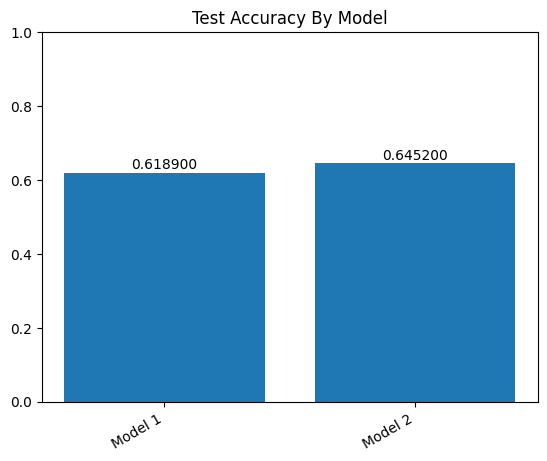

In [162]:
names = []
names = [f'Model {i+1}' for i in range(len(state_dicts))]

plt.bar(names, test_results)
# Add values on top of the bars
for i, value in enumerate(test_results):
    plt.text(i, value + 0.01, f"{value:.6f}", ha='center', fontsize=10)
plt.title("Test Accuracy By Model")
plt.ylim([0,1])
plt.xticks(rotation=30, ha='right')
print(test_results)

# Let's Make Soup! 🍜

From here our next step is to see what happens when we make soup the naïve way using simple averaging. This is called "Uniform Soup."

In [163]:
alphal = [1 / len(state_dicts) for i in range(len(state_dicts))]
model = get_model(state_dicts, alphal)
test_results.append(test(model))

  0%|          | 0/79 [00:00<?, ?it/s]

3


([0, 1, 2],
 [Text(0, 0, 'Model 1'), Text(1, 0, 'Model 2'), Text(2, 0, 'Uniform Soup')])

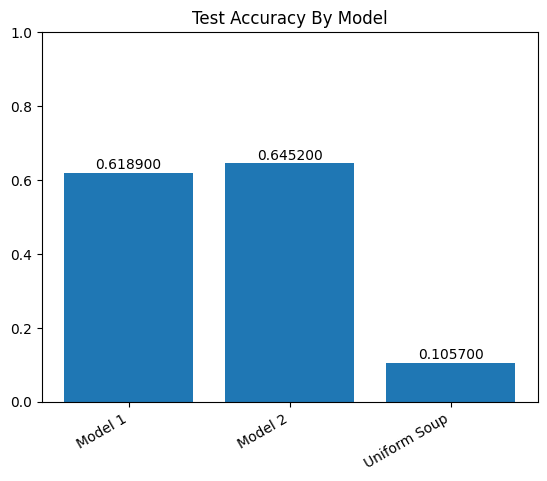

In [164]:
print(len(test_results))
names = []
names.append('Model 1')
names.append('Model 2')
names.append('Uniform Soup')
plt.bar(names, test_results)
plt.title("Test Accuracy By Model")
for i, value in enumerate(test_results):
    plt.text(i, value + 0.01, f"{value:.6f}", ha='center', fontsize=10)
plt.ylim([0,1])
plt.xticks(rotation=30, ha='right')

# Greedy Soup 😈
So how can we improve from our naïve, but still impressive, baseline? The answer is "Greedy Soup!"

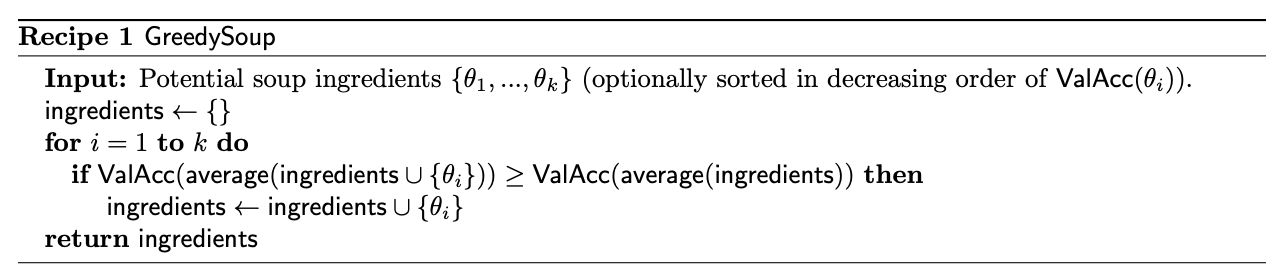

In [119]:
ranked_candidates = [i for i in range(len(state_dicts))]
ranked_candidates.sort(key=lambda x: -val_results[x])

current_best = val_results[ranked_candidates[0]]
best_ingredients = ranked_candidates[:1]
for i in range(1, len(state_dicts)):
  # add current index to the ingredients
  ingredient_indices = best_ingredients \
    + [ranked_candidates[i]]
  alphal = [0 for i in range(len(state_dicts))]
  for j in ingredient_indices:
    alphal[j] = 1 / len(ingredient_indices)

  # benchmark and conditionally append
  model = get_model(state_dicts, alphal)
  current = validate(model)
  print(f'Models {ingredient_indices} got {current*100}% on validation.')
  if current > current_best:
    current_best = current
    best_ingredients = ingredient_indices



  0%|          | 0/40 [00:00<?, ?it/s]

Models [1, 0] got 9.89999994635582% on validation.


In [117]:
alphal = [0 for i in range(len(state_dicts))]
for j in best_ingredients:
  alphal[j] = 1 / len(best_ingredients)
model = get_model(state_dicts, alphal)

test_results.append(test(model))

  0%|          | 0/79 [00:00<?, ?it/s]

In [118]:
print(test_results)
# names.append("Greedy Soup")
# plt.bar(names, test_results)
# plt.title("Test Accuracy By Model")
# plt.ylim([0.95,1])
# plt.xticks(rotation=30, ha='right')

[0.6229999661445618, 0.6189000010490417, 0.09939999878406525, 0.6189000010490417, 0.6189000010490417, 0.6189000010490417]
